<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book2/rl/Tabular_SARSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabular Sarsa Algorithm and the Taxi Environment

Authors: Fred Amouzgar <fred.amouzgar@mq.edu.au> and Kevin Murphy <murphyk@gmail.com>


Tabular methods are suitable for small and discrete state space and discrete action space environments. So, the state-action function (Q) can be represented by a table of values. For large state space environments, we prefer to use approximation methods such as neural networks. However, the simplicity of tabular methods' implementation is helpful to demonstrate RL method's functionality.  In this notebook, we train a SARSA agent for [OpenAI's Taxi Gym](https://gym.openai.com/envs/Taxi-v2/) environment (an example originally proposed by Tom Dietterich).

## 1- Installations

In [6]:

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if not(IS_COLAB):    
  print('not a colab')
  !pip -q install gym numpy matplotlib 

## 2- Setting up the Environment

In [16]:
import gym

# Finding the Taxi environment
for env in gym.envs.registry.all():
    if env.id.startswith("Taxi"):
        env_name = env.id
##


print("Environment Name:", env_name)
env = gym.make(env_name)
env.reset()
env.render()

Environment Name: Taxi-v3
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Here is a description of the taxi environment from the [docstring](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py).


### Description:

There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

### States/ Observations:

State space is (taxi_row, taxi_col, passenger_location, destination).

There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. 


### Passenger locations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
- 4: in taxi

### Destinations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)

### Actions:

There are 6 discrete deterministic actions:
- 0: move south
- 1: move north
- 2: move east
- 3: move west
- 4: pickup passenger
- 5: drop off passenger


Notice in this environment the taxi cannot perform certain actions in certain states due to walls. In environment's code, we will simply provide a -1 penalty for every wall hit and the taxi won't move anywhere. This will just rack up penalties causing the taxi to consider going around the wall.

### Rewards:

There is a default per-step reward of -1,
except for delivering the passenger, which is +20,
or executing "pickup" and "drop-off" actions illegally, which is -10.

### Rendering:
- blue: passenger
- magenta: destination
- yellow: empty taxi
- green: full taxi
- other letters (R, G, Y and B): locations for passengers and destinations



## 3- Developing the SARSA agent

<img src="https://github.com/probml/pyprobml/blob/master/book2/rl/figures/SARSA_algorithm.png?raw=1" width="800">

Here's the full update formula covered in line 7 and 8:
<img src="https://github.com/probml/pyprobml/blob/master/book2/rl/figures/SARSA_formula.png?raw=1" width="500">

In [2]:
import numpy as np
import pickle


class Sarsa_Agent:
    def __init__(
        self,
        states_n,
        actions_n,
        learning_rate=0.2,
        epsilon=0.1,
        gamma=0.95,
        epsilon_decay=True,
        epsilon_decay_factor=0.01,
    ):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.gamma = gamma
        self.states_n = states_n
        self.actions_n = actions_n
        self.Q = np.zeros((states_n, actions_n))
        self.new_a = None
        self.epsilon_decay = epsilon_decay
        self.epsilon_decay_factor = epsilon_decay_factor

    def act(self, state):
        """The act method implements the epsilon-greedy policy"""
        if np.random.rand() < self.epsilon:
            act = np.random.choice(np.arange(self.actions_n))
        else:
            act = np.argmax(self.Q[int(state), :])
        return act

    def decay_epsilon(self, factor):
        """Decaying the epsilon, so it gradualy reduces the exploration and exploits more"""
        self.epsilon -= factor if self.epsilon >= 0 else 0

    def update(self, new_s, r, s, a, done):
        """The update method updates the agent for one step"""
        self.new_a = self.act(new_s)
        mask = 0 if done else 1
        s, a, self.new_a, new_s = int(s), int(a), int(self.new_a), int(new_s)
        self.Q[s, a] += self.learning_rate * (r + self.gamma * self.Q[new_s, self.new_a] * mask - self.Q[s, a])
        if done and self.epsilon_decay:
            self.decay_epsilon(self.epsilon_decay_factor)
        return self.new_a

    def save(self, file_name="taxi.pkl"):
        """The save method saves (pickles) the agent's Q table"""
        with open(file_name, mode="wb") as f:
            pickle.dump(self.Q, f)

    def load(self, file_name="taxi.pkl"):
        """The load method loads a pickled Q table"""
        with open(file_name, mode="rb") as f:
            self.Q = pickle.load(f)

## 4- Defining the Training Loop

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from time import sleep
import numpy as np


def train_taxi(env, agent, episodes=150):
    if env is None:
        raise ValueError("No Environment is given.")
    if agent is None:
        raise ValueError("No agent is given.")

    steps = []
    returns = []
    for episode in range(episodes):
        state = env.reset()
        action = agent.act(state)
        done = False
        step_n = 0
        return_episode = 0
        while not done:
            new_state, reward, done, _ = env.step(action)
            return_episode += reward
            new_action = agent.update(new_state, reward, state, action, done)
            state, action = new_state, new_action
            step_n += 1
            if done:
                steps.append(step_n)
                returns.append(return_episode)
                clear_output(wait=True)
                plt.title("Steps:" + str(step_n) + " Return:" + str(return_episode))
                plt.plot(list(range(len(steps))), steps)
                plt.plot(list(range(len(steps))), returns)
                plt.legend(["Steps", "Returns"])
                plt.show()

## 5- Let's train our agent for 1500 episodes (takes ~5 minutes)

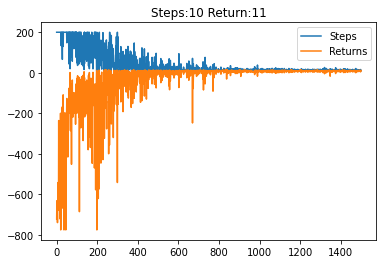

In [4]:
agent = Sarsa_Agent(env.observation_space.n, env.action_space.n, epsilon_decay=True)

train_taxi(env, agent, episodes=1500)
agent.save()

## 6- Methods for Playing and Rendering the Taxi environment in the notebook

In [7]:
def taxi_print_frames(frames, wait_btw_frames, episode):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame["frame"])
        print(f"Passenger #: {episode + 1}")
        print("-----------")
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(wait_btw_frames)


def play_taxi(env, agent, passengers=2, wait_btw_frames=1):
    for episode in range(passengers):
        state = env.reset()
        frames = []
        done = False
        step = 0
        while not done:
            action = agent.act(state)
            new_state, reward, done, _ = env.step(action)
            frames.append({"frame": env.render(mode="ansi"), "state": state, "action": action, "reward": reward})
            step += 1
            state = new_state
        taxi_print_frames(frames, wait_btw_frames=wait_btw_frames, episode=episode)

## 7- Watch a Trained SARSA Cab Driver

Note: You can change the number of passengers if you want to move more than 3. Change the wait_btw_frames if you want to see the game running faster or slower.

In [8]:
play_taxi(env, agent, passengers=3, wait_btw_frames=1)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Passenger #: 3
-----------
Timestep: 10
State: 479
Action: 5
Reward: 20
